In [1]:
from cif import cif
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [2]:
database = cif.createOneCountryDataFrameFromOECD('USA', 'MEI', 
                                     frequency='Q', startDate='1990-Q1')
usa_df = database[0]
labelvar = database[1]

Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/USA...Q/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/USA...Q/all?startTime=1990-Q1&dimensionAtObservation=AllDimensions


In [3]:
usa_df

subject B6BLPI01                            B6BLSE01                    \
measure     CXCU   CXCUSA     NCCU   NCCUSA     CXCU   CXCUSA     NCCU   
time                                                                     
1990-Q1   6667.0   5928.0   6667.0   5928.0   8101.0   6843.0   8101.0   
1990-Q2   6120.0   6406.0   6120.0   6406.0   5695.0   7224.0   5695.0   
1990-Q3   3862.0   5227.0   3862.0   5227.0   6986.0   7479.0   6986.0   
1990-Q4  11900.0  10988.0  11900.0  10988.0   9391.0   8633.0   9391.0   
1991-Q1   8663.0   8108.0   8663.0   8108.0   9362.0   8090.0   9362.0   
...          ...      ...      ...      ...      ...      ...      ...   
2019-Q3  61172.0  61621.0  61172.0  61621.0  70601.0  71471.0  70601.0   
2019-Q4  61787.0  61958.0  61787.0  61958.0  82290.0  72738.0  82290.0   
2020-Q1  52895.0  52036.0  52895.0  52036.0  61737.0  65272.0  61737.0   
2020-Q2  29307.0  29213.0  29307.0  29213.0  53318.0  54440.0  53318.0   
2020-Q3      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

subject          B6BLSI01           ...   XTIMVA01                       \
measure   NCCUSA     CXCU   CXCUSA  ...       GPSA       GYSA      NCML   
time                                ...                                   
1990-Q1   6843.0  -6643.0  -6540.0  ...   2.188316   5.678085  119.7550   
1990-Q2   7224.0  -7331.0  -7644.0  ...  -1.055037   1.448198  120.9364   
1990-Q3   7479.0  -7213.0  -7339.0  ...   2.784438   5.201709  124.3284   
1990-Q4   8633.0  -5467.0  -5133.0  ...   1.986900   5.990437  130.2908   
1991-Q1   8090.0  14721.0  14828.0  ...  -5.780600  -2.274978  115.9279   
...          ...      ...      ...  ...        ...        ...       ...   
2019-Q3  71471.0 -33794.0 -33556.0  ...  -0.554719  -2.219772  641.1710   
2019-Q4  72738.0 -36952.0 -36524.0  ...  -2.797840  -5.398035  621.1790   
2020-Q1  65272.0 -36864.0 -37075.0  ...  -3.037014  -6.230327  569.0640   
2020-Q2  54440.0 -34513.0 -34856.0  ... -14.468203 -19.833362  509.0920   
2020-Q3      NaN      NaN      NaN  ...  18.501470  -4.471440  610.6930   

subject                       XTNTVA01                                          
measure    NCMLSA       STSA      CXML    CXMLSA      NCML    NCMLSA      STSA  
time                                                                            
1990-Q1  122.3748   8.335163  -22.1585  -25.8646  -22.1585  -25.8646 -1.761683  
1990-Q2  121.0837   8.126385  -20.3104  -22.8322  -20.3104  -22.8322 -1.532355  
1990-Q3  124.4552   8.276163  -30.4250  -27.2787  -30.4250  -27.2787 -1.814010  
1990-Q4  126.9280   8.455197  -28.8245  -25.0540  -28.8245  -25.0540 -1.668950  
1991-Q1  119.5908   7.926248  -13.1684  -17.2519  -13.1684  -17.2519 -1.143423  
...           ...        ...       ...       ...       ...       ...       ...  
2019-Q3  627.0910  11.644968 -235.5700 -218.4390 -235.5700 -218.4390 -4.056373  
2019-Q4  609.5460  11.211385 -206.5630 -200.2780 -206.5630 -200.2780 -3.683715  
2020-Q1  591.0340  10.964801 -173.3290 -189.3410 -173.3290 -189.3410 -3.512634  
2020-Q2  505.5220  10.358997 -217.6880 -217.0510 -217.6880 -217.0510 -4.447740  
2020-Q3  599.0510  11.325756 -258.3530 -242.4530 -258.3530 -242.4530 -4.583856  

[123 rows x 792 columns]

In [4]:
##--- Création d'un dataframe pour USA ----

liste_var = ['NAEXKP01', 'LREMTTTT', 'LRACTTTT', 'LRUNTTTT', 
             'NAEXKP02', 'NAEXKP04', 'NAEXKP06']

headers = ['PIB', 'Emplois', 'Actifs', 'Chomage', 'Conso', 
           'Formation', 'Exports']

d = {col:var_df for col, var_df in zip(headers, [usa_df['{0}'.format(var)]["STSA"] for var in liste_var] )}
usa_bon_df = pd.DataFrame(d)

In [5]:
usa_bon_df

,PIB,Emplois,Actifs,Chomage,Conso,Formation,Exports
time,,,,,,,
1990-Q1,9358.289,63.200000,66.733333,5.300000,5998.058,1695.374,682.300
1990-Q2,9392.251,63.000000,66.533333,5.333333,6016.329,1668.437,690.785
1990-Q3,9398.499,62.666667,66.466667,5.700000,6040.163,1659.143,696.014
1990-Q4,9312.937,62.333333,66.400000,6.133333,5994.212,1628.395,702.143
1991-Q1,9269.367,61.900000,66.233333,6.600000,5971.672,1587.408,706.434
...,...,...,...,...,...,...,...
2019-Q3,19141.744,60.866667,63.133333,3.633333,13301.349,4054.506,2536.562
2019-Q4,19253.959,61.000000,63.233333,3.533333,13353.687,4075.404,2557.846
2020-Q1,19010.848,60.766667,63.166667,3.833333,13118.406,4075.494,2495.099


In [6]:
## Créons d'abord une colonne time qui donne la date sous le format AAAA-MM-JJ

qs = usa_bon_df.index.str.replace(r'(Q\d) (\d+)', r'\2-\1')
usa_bon_df['date'] = pd.PeriodIndex(qs, freq='Q').to_timestamp()
usa_bon_df = usa_bon_df.reindex(index=usa_bon_df['date'])
#usa_bon_df = usa_bon_df.drop("date", axis=1)
usa_bon_df

,PIB,Emplois,Actifs,Chomage,Conso,Formation,Exports,date
date,,,,,,,,
1990-01-01,9358.289,63.200000,66.733333,5.300000,5998.058,1695.374,682.300,1990-01-01
1990-04-01,9392.251,63.000000,66.533333,5.333333,6016.329,1668.437,690.785,1990-04-01
1990-07-01,9398.499,62.666667,66.466667,5.700000,6040.163,1659.143,696.014,1990-07-01
1990-10-01,9312.937,62.333333,66.400000,6.133333,5994.212,1628.395,702.143,1990-10-01
1991-01-01,9269.367,61.900000,66.233333,6.600000,5971.672,1587.408,706.434,1991-01-01
...,...,...,...,...,...,...,...,...
2019-07-01,19141.744,60.866667,63.133333,3.633333,13301.349,4054.506,2536.562,2019-07-01
2019-10-01,19253.959,61.000000,63.233333,3.533333,13353.687,4075.404,2557.846,2019-10-01
2020-01-01,19010.848,60.766667,63.166667,3.833333,13118.406,4075.494,2495.099,2020-01-01


In [26]:
## ------ Stat Des -------------

sns.set(style="darkgrid") #pour ceux qui ont une vieille version
#sns.set_theme(style="darkgrid")

#On calcule des moyennes mobiles du PIB sur toute la période pour essayer d'en extraire la tendance : 

usa_bon_df['Moyenne mobile PIB'] = usa_bon_df[['PIB','date']].rolling(window = 16,center = True,on = 'date').sum().drop('date', axis = 1)/16

#on calcule le résidu du pib : 

usa_bon_df['résidu PIB'] = usa_bon_df ['PIB'] - usa_bon_df['Moyenne mobile PIB'] 

#PIB_graph = sns.lineplot(data=usa_bon_df, x= 'date', y='PIB')
#PIB_graph.set_title("Évolution du PIB américain depuis 1990")



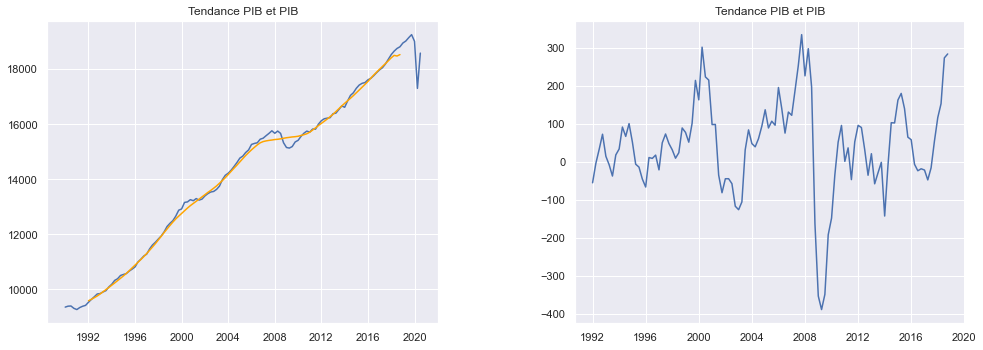

In [46]:
#On plot ces deux séries qu'on a obtenu : 
plt.figure(figsize=(15,5))

#Tendance du PIB :
plt.subplot(121)
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['PIB'].to_numpy())
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['Moyenne mobile PIB'], color = 'orange')
plt.title('Tendance PIB et PIB')
plt.grid(True)

#Résidus : 
plt.subplot(122)
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['résidu PIB'].to_numpy())
plt.title('résidu du PIB')
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)

plt.show()

In [21]:
#On va calculer la moyenne mobile sur deux ans des séries du chomage et des exports : 
usa_bon_df['Moyenne mobile chomage'] = usa_bon_df[['Chomage','date']].rolling(window = 16,center = True,on = 'date').sum().drop('date', axis = 1)/16

usa_bon_df['Moyenne mobile exports'] = usa_bon_df[['Exports','date']].rolling(window = 16,center = True,on = 'date').sum().drop('date', axis = 1)/16

#Note : c'est normal que l'on ai pas les 8 premières et dernières valeurs puisque c'est une moyenne glissante centrée

#on calcule aussi les résidus sur les deux séries :

usa_bon_df['résidu exports'] = usa_bon_df ['Exports'] - usa_bon_df['Moyenne mobile exports'] 
usa_bon_df['résidu chomage'] = usa_bon_df ['Chomage'] - usa_bon_df['Moyenne mobile chomage'] 


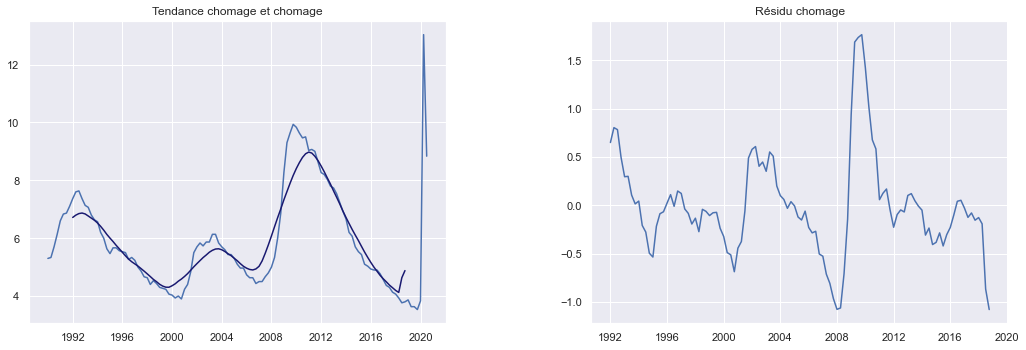

In [43]:
# On plot les séries du chômage :
plt.figure(figsize=(16,5))

# Chomage et tendance
plt.subplot(121)
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['Chomage'].to_numpy())
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['Moyenne mobile chomage'], color = 'midnightblue')
plt.title('Tendance chomage et chomage')
plt.grid(True)


# résidus
plt.subplot(122)
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['résidu chomage'].to_numpy())
plt.title('Résidu chomage')
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)

plt.show()

On peut voir ici que le chomage est extrêment variable sur toute la période et qu'aucune tendance ne semble vraiment se dégager (même la courbe des moyennes mobiles est très variables).

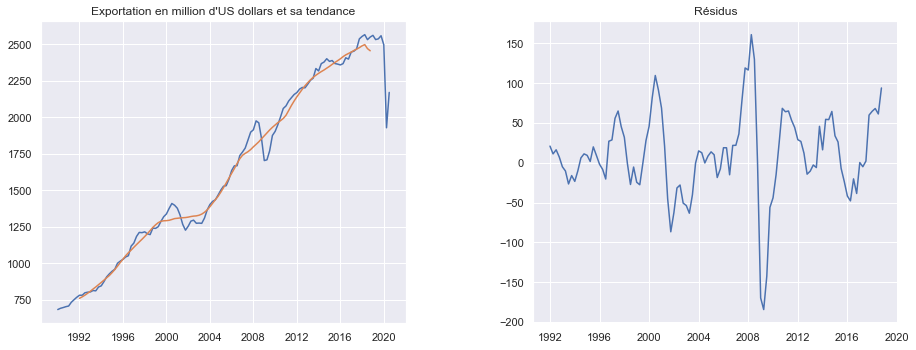

In [18]:
#On plot la série des exports : 
plt.figure(figsize=(14,5))
# exports
plt.subplot(121)
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['Exports'].to_numpy())
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['Moyenne mobile exports'].to_numpy())
plt.title('Exportation en million d\'US dollars et sa tendance')
plt.grid(True)

# résidus
plt.subplot(122)
plt.plot(usa_bon_df['date'].to_numpy(),usa_bon_df['résidu exports'].to_numpy())
plt.title('Résidus')
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)

plt.show()

On peut voir ici qu'il semble y avoir une tendance à la hausse des exportations, bien que celle ci soit bruité par les différents chocs sur l'économie : en effet on peut voir que la crise de 2008 n'a pas été sans effet sur celles-ci, et de même dans les années 2000 et 2001 les attentats du 11 novembre et l'éclatement de la bulle internet ont probablement freiné la croissance des exportations.

In [12]:
#Préparation pour test stationnaire
PIB_temp = usa_bon_df['PIB']

In [13]:
# SARIMAX
mdl = sm.tsa.statespace.SARIMAX(PIB_temp,order=(0, 0, 0),seasonal_order=(2, 2, 1, 7),enforce_stationarity=True,enforce_invertibility=True)
res = mdl.fit()

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


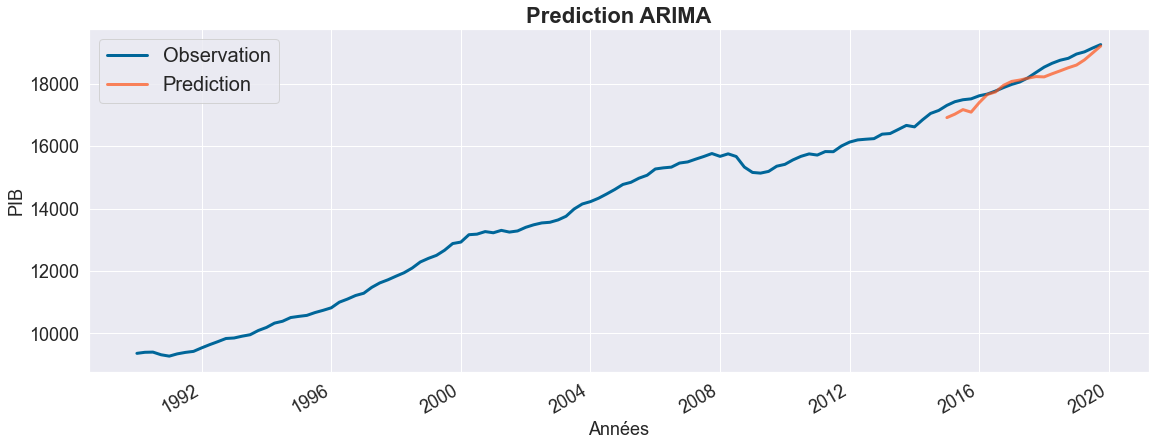

<ipython-input-14-d3cb16f8586c>:26: RuntimeWarning: Mean of empty slice.
  rmse = math.sqrt(((pred.predicted_mean.values.reshape(-1, 1) - PIB_temp[200:].values) ** 2).mean())
C:\Users\Asus\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
# fit model to data
res = sm.tsa.statespace.SARIMAX(PIB_temp,
                                order=(0, 0, 0),
                                seasonal_order=(2, 2, 1, 7),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()

# in-sample-prediction and confidence bounds
pred = res.get_prediction(start = "2015-01-01", 
                          end = "2019-10-01",
                          dynamic = False, 
                          full_results=True)


 # plot in-sample-prediction
fig = plt.figure(figsize=(19, 7))
ax = fig.add_subplot(111)
ax.plot(PIB_temp[0:120],color='#006699',linewidth = 3, label='Observation');
pred.predicted_mean.plot(ax=ax,linewidth = 3, linestyle='-', label='Prediction', alpha=.7, color='#ff5318', fontsize=18);
ax.set_xlabel('Années', fontsize=18)
ax.set_ylabel('PIB', fontsize=18)
plt.legend(loc='upper left', prop={'size': 20})
plt.title('Prediction ARIMA', fontsize=22, fontweight="bold")
plt.show()

rmse = math.sqrt(((pred.predicted_mean.values.reshape(-1, 1) - PIB_temp[200:].values) ** 2).mean())

In [23]:
usa_bon_df.head(15)

,PIB,Emplois,Actifs,Chomage,Conso,Formation,Exports,date,Moyenne mobile chomage,Moyenne mobile exports,résidu exports,résidu chomage
date,,,,,,,,,,,,
1990-01-01,9358.289,63.200000,66.733333,5.300000,5998.058,1695.374,682.300,1990-01-01,NaN,NaN,NaN,NaN
1990-04-01,9392.251,63.000000,66.533333,5.333333,6016.329,1668.437,690.785,1990-04-01,NaN,NaN,NaN,NaN
1990-07-01,9398.499,62.666667,66.466667,5.700000,6040.163,1659.143,696.014,1990-07-01,NaN,NaN,NaN,NaN
1990-10-01,9312.937,62.333333,66.400000,6.133333,5994.212,1628.395,702.143,1990-10-01,NaN,NaN,NaN,NaN
1991-01-01,9269.367,61.900000,66.233333,6.600000,5971.672,1587.408,706.434,1991-01-01,NaN,NaN,NaN,NaN
1991-04-01,9341.642,61.766667,66.266667,6.833333,6021.163,1596.569,732.190,1991-04-01,NaN,NaN,NaN,NaN
1991-07-01,9388.845,61.566667,66.100000,6.866667,6051.184,1596.484,749.521,1991-07-01,NaN,NaN,NaN,NaN
1991-10-01,9421.565,61.366667,66.066667,7.100000,6048.156,1597.712,766.393,1991-10-01,NaN,NaN,NaN,NaN
1992-01-01,9534.346,61.433333,66.300000,7.366667,6161.398,1619.962,780.240,1992-01-01,6.716667,759.229438,21.010562,0.650000


In [15]:
print(res.summary())

                                 SARIMAX Results                                 
Dep. Variable:                       PIB   No. Observations:                  123
Model:             SARIMAX(2, 2, [1], 7)   Log Likelihood                -815.285
Date:                   Fri, 11 Dec 2020   AIC                           1638.570
Time:                           15:48:07   BIC                           1649.335
Sample:                       01-01-1990   HQIC                          1642.935
                            - 07-01-2020                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.1888      0.204      0.927      0.354      -0.210       0.588
ar.S.L14      -0.0895      0.155     -0.578      0.563      -0.393       0.214
ma.S.L7       -0.7904      0